In [1]:
import matplotlib.pyplot as plt
import time
import os
import pickle

import torch
import numpy as np

from sbi import analysis
from sbi import utils as utils
from sbi.utils.user_input_checks import process_prior

#from simulations_model1 import simulator_sbi_entropy
from simulations_model2 import simulator_sbi_entropy
from parsing_functions import save_pickle_data, load_inference_data, extract_specs

from tqdm.notebook import tqdm  # Use tqdm if you're not in a notebook environment

In [2]:
def compute_entropies(n_points, samplings, theta_true, simulator_to_sbi_entropy, posterior):
    # Declare the lists inside the function
    x_obs = []
    S = []
    samples = []
    sample_pars = []
    S_true = []
    S_true_analytic = []
    
    # Use tqdm to show progress
    for i in tqdm(range(n_points), desc="Computing entropies"):
        x_obs1, S1, S1analytic = simulator_to_sbi_entropy(theta_true[i])
        x_obs.append(x_obs1)
        S.append(S1)
        samples.append(posterior.sample((samplings,), x=x_obs[i], show_progress_bars=False))
        sample_pars.append(torch.mean(samples[i], dim=0))
        x_obs_true1, S_true1, S_true1analytic = simulator_to_sbi_entropy(sample_pars[i])
        S_true.append(S_true1)
        S_true_analytic.append(S_true1analytic)
    return S, S_true, S_true_analytic

In [3]:
posterior_dir = 'saved_posteriors/model2/'
posterior_name = 'posterior_10000sim_5e+04np_1e-02dt_5os_1e+03pre.pickle'
posterior_path = os.path.join(posterior_dir, posterior_name)

# Extract the specifications
specs_dict = extract_specs(posterior_path)
print(specs_dict)
# Unpack the specifications from the dictionary
num_simulations = specs_dict['num_simulations']
Npts = specs_dict['Npts']
dt = specs_dict['dt']
oversampling = specs_dict['oversampling']
prerun = specs_dict['prerun']

prefix = specs_dict['prefix']
data_type = specs_dict['data_type']

high_tensor = specs_dict['high_tensor']
low_tensor = specs_dict['low_tensor']
features = specs_dict['features']

with open(posterior_path, "rb") as handle:
    data_posterior = pickle.load(handle)

posterior = data_posterior['posterior']

{'num_simulations': 10000, 'Npts': 50000.0, 'dt': 0.01, 'oversampling': 5, 'prerun': 1000.0, 'low_tensor': tensor([0.0000, 0.0100, 0.0000]), 'high_tensor': tensor([2, 2, 1]), 'data_type': 'full', 'prefix': None, 'features': ['Cxx', 'Cyy', 'S_red_x', 'S_red_y']}


In [4]:
def simulator_to_sbi_entropy(pars):
    return simulator_sbi_entropy(np.array(pars), dt, int(oversampling), int(prerun),int(Npts), features = features)

prior_sbi = utils.BoxUniform(low=low_tensor, high=high_tensor)

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_sbi)

In [10]:
theta_true = prior.sample((1,))
print(theta_true)
# generate our observation
x_obs, S, S_analytic = simulator_to_sbi_entropy(theta_true[0])
samples = posterior.sample((250000,), x=x_obs)

logprob = posterior.log_prob(theta_true, x=x_obs)
print(logprob)

tensor([[1.0681, 1.8231, 0.3754]])


Drawing 250000 posterior samples:   0%|          | 0/250000 [00:00<?, ?it/s]

tensor([2.1064])


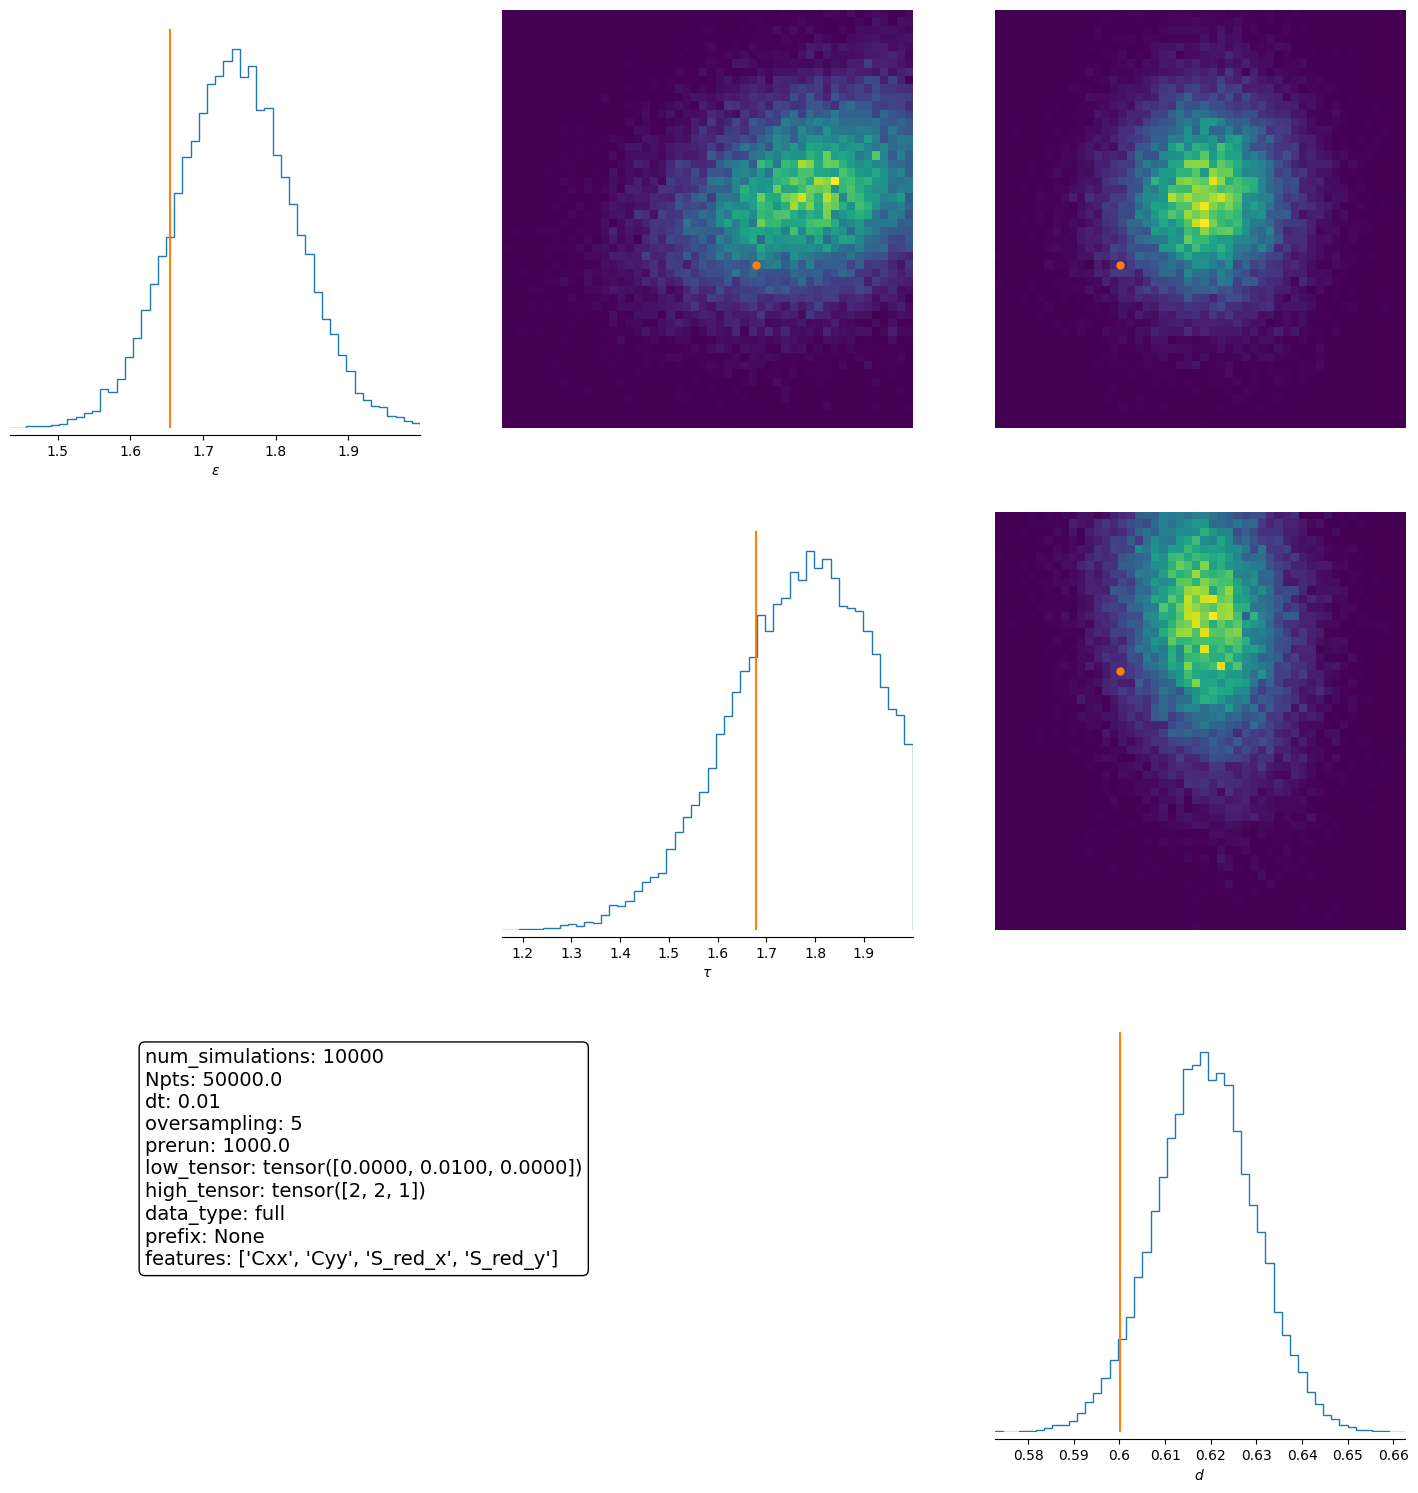

In [6]:
fig,ax = analysis.pairplot(samples, points=theta_true, figsize=(18, 18),labels=[r"$\epsilon$", r"$\tau$", r"$d$"])

fig_save_dir = 'saved_figures/model2/'
fig_name = 'analysisSNPE_' + str(specs_dict).replace(' ', '_').replace(':', '_').replace(',', '_').replace("'", "").replace("{", "").replace("}", "").replace("\n", "") +'.png'

# Convert metadata dictionary to a string
metadata_text = "\n".join([f"{key}: {value}" for key, value in specs_dict.items()])

# Add text box with metadata
text_box = fig.text(
    0.2, 0.2, metadata_text,
    fontsize=14,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=1, boxstyle='round,pad=0.3')
)

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir): os.makedirs(fig_save_dir)
fig_path = os.path.join(fig_save_dir, fig_name)

fig.savefig(fig_path, dpi = 300)

In [7]:
n_points = 50
samplings = 50_000
theta_trues = prior.sample((n_points,))

S, S_true, S_true_analytic = compute_entropies(n_points, samplings, theta_trues, simulator_to_sbi_entropy, posterior)

Computing entropies:   0%|          | 0/50 [00:00<?, ?it/s]

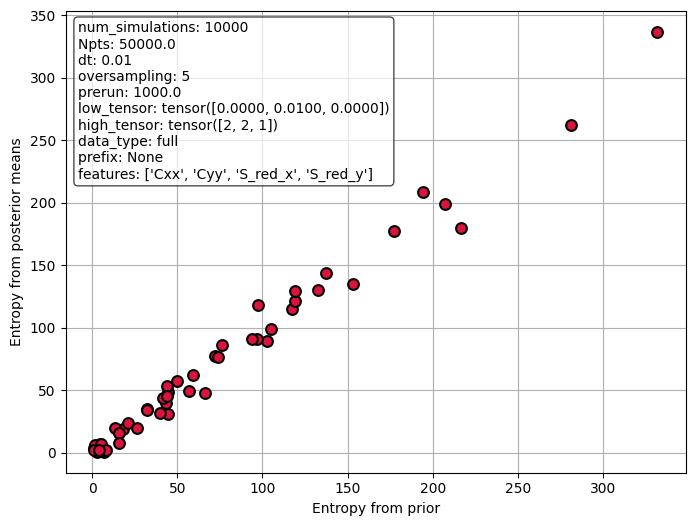

In [8]:
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
s=60
ax2.scatter(np.array(S),np.array(S_true),s=s,edgecolor='black',lw=1.5,facecolor='crimson',zorder=2)
#xx = np.linspace(0,500,100)
#ax.plot(xx,xx,zorder=0,color='dimgray')
#ax.set_xscale('log')
#ax.set_yscale('log')


# Add text box with metadata
text_box = fig2.text(
    0.02, .63, metadata_text,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='left',
    transform=ax2.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Add labels and grid
ax2.set_xlabel("Entropy from prior")
ax2.set_ylabel("Entropy from posterior means")
ax2.grid(True)

fig_save_dir2 = 'saved_plots/model2/'
fig_name2 = 'entropySNPE_' + str(specs_dict).replace(' ', '_').replace(':', '_').replace(',', '_').replace("'", "").replace("{", "").replace("}", "").replace("\n", "") + '.png'

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir): os.makedirs(fig_save_dir)
fig_path2 = os.path.join(fig_save_dir2, fig_name2)

fig2.savefig(fig_path2, dpi = 300)

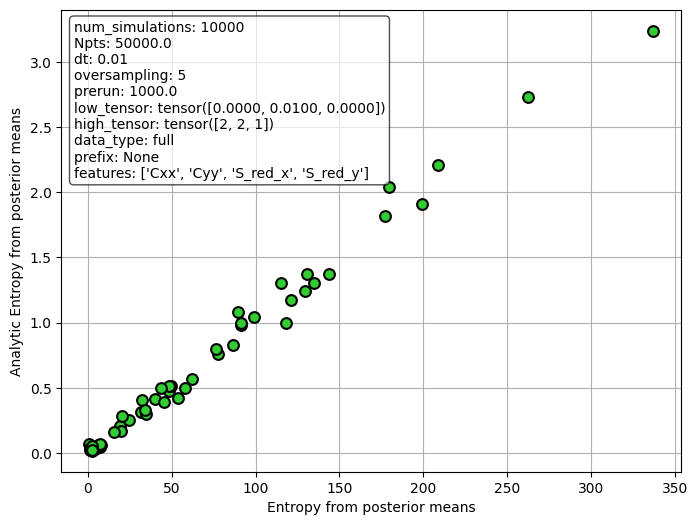

In [14]:
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
s=60
ax2.scatter(np.array(S_true),np.array(S_true_analytic),s=s,edgecolor='black',lw=1.5,facecolor='limegreen',zorder=2)
#xx = np.linspace(0,500,100)
#ax.plot(xx,xx,zorder=0,color='dimgray')
#ax.set_xscale('log')
#ax.set_yscale('log')


# Add text box with metadata
text_box = fig2.text(
    0.02, .63, metadata_text,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='left',
    transform=ax2.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Add labels and grid
ax2.set_xlabel("Entropy from posterior means")
ax2.set_ylabel("Analytic Entropy from posterior means")
ax2.grid(True)

fig_save_dir2 = 'saved_plots/model2/'
fig_name2 = 'entropyanalyticSNPE_' + str(specs_dict).replace(' ', '_').replace(':', '_').replace(',', '_').replace("'", "").replace("{", "").replace("}", "").replace("\n", "") + '.png'

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir): os.makedirs(fig_save_dir)
fig_path2 = os.path.join(fig_save_dir2, fig_name2)

fig2.savefig(fig_path2, dpi = 300)